# Алгоритмы работы с изображениями

В настоящей тетради мы изучим основные алгоритмы извлечения признаков, а также методы
создания машинного обучения для выявления этих самых признаков.

***

## Подготовка изображения

Для начала выполним необходимые импорты. OpenCV мы будем использовать практически для всех задач, а matplotlib только для визуализации (что, на самом деле, неудивительно). После выполним некоторые необходимые манипуляции над изображением.

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

Загрузим изображение замка и выведем его на экран.

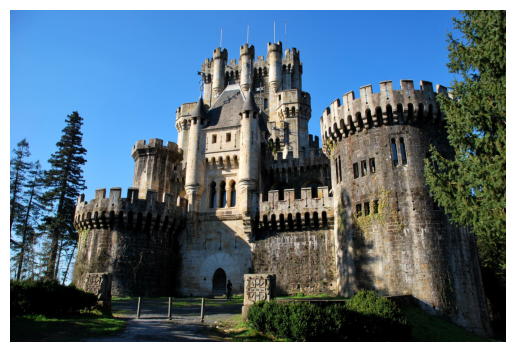

In [2]:
image = cv.imread("../images/castle.jpg")

plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Применим базовые методы предобработки изображений, такие как изменение размера, преобразование в оттенки серого 
и улучшение контраста.

Сначала изменим размер изображения.

In [3]:
new_width, new_hight = 3800, 2500
image_resized = cv.resize(image, (new_width, new_hight))

Теперь преобразуем в оттенки серого.

In [4]:
image_grayscale = cv.cvtColor(image_resized, cv.COLOR_BGR2GRAY)

Увеличим контрастность.

In [5]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image_clahe = clahe.apply(image_grayscale)

Теперь взглянем на то, что в итоге вышло.

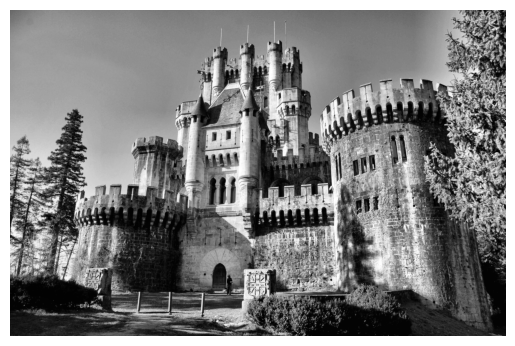

In [6]:
plt.imshow(image_clahe)
plt.axis("off")
plt.gray()
plt.show()

С получившимся изображением уже будем работать.

***

## Извлечение признаков

Используем алгоритмы извлечения признаков, такие как: детектор углов Харриса, SIFT (Scale-Invariant Feature Transform) и ORB (Oriented FAST and Rotated BRIEF). Здесь мы будем лишь показывать, где данные алгоритмы расположат ключевые точки, которые нам так интересны. Непосредственно для вычисления значений признаков у каждого дескриптора (кроме детектора углов Харриса) имеется метод `compute()`, однако в сейчас он нам не пригодится, так как мы хотим лишь проиллюстрировать видимый эффект от применения того или иного алгоритма.).

Применим сперва детектор углов Харриса.

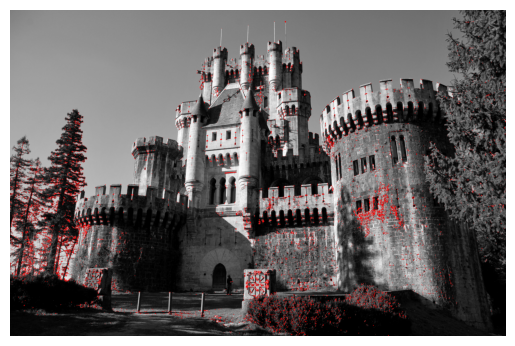

In [7]:
# Detect corners on the image
corners = cv.cornerHarris(image_grayscale, blockSize=3, ksize=5, k=0.01)
image_corners_harris = cv.cvtColor(image_grayscale, cv.COLOR_GRAY2BGR)
# Draw the key points with red
image_corners_harris[corners > 0.01 * corners.max()] = [255, 0, 0]

plt.imshow(image_corners_harris)
plt.axis("off")
plt.show()

Теперь посмотрим, как применение SIFT изменит наше изображение.

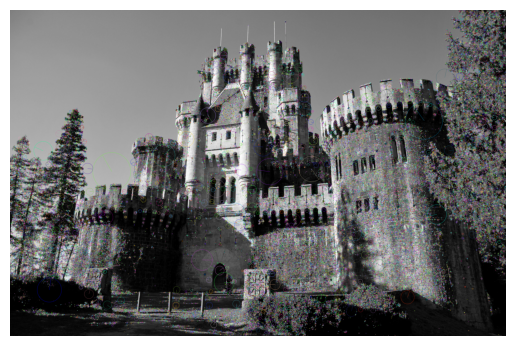

In [8]:
# Initialize the SIFT descriptor
sift = cv.SIFT_create()
# Detect key points
key_points = sift.detect(image_grayscale, None)
# Draw key points that vary in size corresponding to the feature value
image_corners_sift = cv.drawKeypoints(
    image_grayscale,
    key_points,
    None,
    flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

plt.imshow(image_corners_sift)
plt.axis("off")
plt.show()

И, наконец, рассмотрим случай использования ORB.

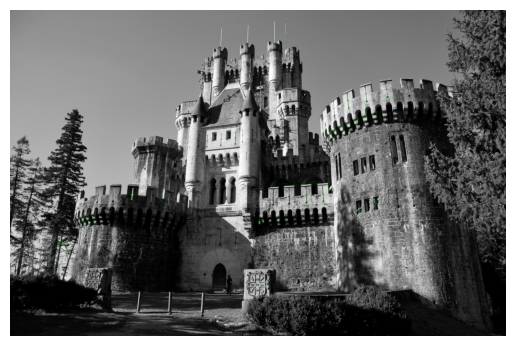

In [9]:
# Initialize the ORB descriptor
orb = cv.ORB_create()
# Detect key points
key_points = orb.detect(image_grayscale, None)
# Draw key points with green
image_corners_orb = cv.drawKeypoints(
    image_grayscale,
    key_points,
    None,
    color=(0, 255, 0),
    flags=0,
)

plt.imshow(image_corners_orb)
plt.axis("off")
plt.show()

Можно наблюдать видимое различие между эффектами, которые дескрипторы оказывают на изображения. Например: детектор углов Харриса хорошо справился с разметкой углов на замке, но сильно нашумел на деревьях по левую сторону и плохо различил углы в тени; SIFT довольно неплохо отличил почти все углы на изображении; ORB большую часть менее очевидных изгибов проигнорировал, в то время как выявил наиболее заметные.

***

## Соответствие признаков

Теперь посмотрим, как можно применять так называемый `Mather` для обнаружения соответствий признаков. Если вкратце, `Matcher` при помощи дескриптора сопоставляет признак из первого множества со всеми признаками из второго на основе некоторой метрики расстояния. Мы посмотрим как пользоваться `BFMatcher`'ом в купе с дескрипторами ORB и SIFT и тестом отношения..

### Соответствие грубой силой с ORB

В этом подразделе можно наблюдать пример выполнения обнаружения соответствий признаков. Изображение признаки которого мы будем искать на сцене называют query image, а саму сцену — train image. В качестве изображений возьмём Девятый Вал Айвазовского и эту же картину только уже в галерее.

Сперва загрузим наши изображения.

In [10]:
query_image, train_image = (
    cv.imread("../images/aivazovsky-query-image.jpg", cv.IMREAD_GRAYSCALE),
    cv.imread("../images/aivazovsky-train-image.jpg", cv.IMREAD_GRAYSCALE),
)

Воспользуемся уже знакомым нам ORB для обнаружения признаков и вычисления значений дескриптора. Маска в данном случае нам не нужна, поэтому устанавливаем второй аргумент равным `None`.

In [11]:
orb = cv.ORB_create()
key_points_query, descriptor_query = orb.detectAndCompute(query_image, None)
key_points_train, descriptor_train = orb.detectAndCompute(train_image, None)

Инициализируем детектор соответствий с метрикой Хэммингова расстояния и включённой перекрёстной проверкой. После дадим ему обнаружить соовтетствия параметров и отсортируем полученные совпадения от наиболее к менее очевидным для алгоритма.

In [12]:
bfm = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bfm.match(descriptor_query, descriptor_train)
matches = sorted(matches, key=lambda match: match.distance)

Теперь отрисуем первые 12 вычисленных соответствий. Слева будет сама картина, а справа её инсталляция в галерее.

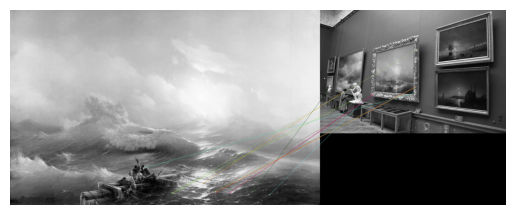

In [13]:
mathing_images = cv.drawMatches(
    query_image,
    key_points_query,
    train_image,
    key_points_train,
    matches[:12],
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

plt.imshow(mathing_images)
plt.axis("off")
plt.show()

Можно наблюдать, как алгоритм вполне удачно оличил человека в лодке и некоторые черты самой лодки, нарисовал линии, соединяющие совпавшие признаки.

### Соответствие грубой силой с SIFT и тестом отношения

В этот раз уже без надобности заново загржать картинки. Все утверждения относительно детектора соответствий остаются прежними. Лишь только тперь мы будем пользоваться иным методом — `knnMatch()`. Приступим сразу к эксперименту.

Переопределим алгоритм и так же вычислим ключевые точки и значения дескриптора.

In [14]:
sift = cv.SIFT_create()
key_points_query, descriptor_query = sift.detectAndCompute(query_image, None)
key_points_train, descriptor_query = sift.detectAndCompute(train_image, None)

Определим детектор соответствий с параметрами по умолчанию. Найдём с его помощью самые соответствия. Детектор будет рассматривать 3 ближайших соответствия.

In [15]:
bfm = cv.BFMatcher()
matches = bfm.knnMatch(descriptor_query, descriptor_query, k=2)

Выполним теперь тестирование отношений.

In [16]:
best_matches = list()
for query, train in matches:
    if query.distance < 0.75 * train.distance:
        best_matches.append([query])

Отобразим соответствия и посмотрим на результат.

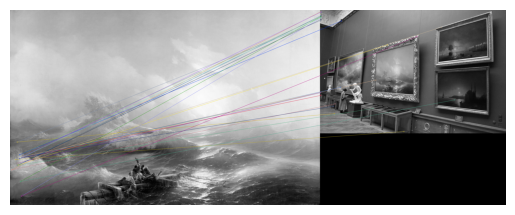

In [17]:
mathing_images = cv.drawMatchesKnn(
    query_image,
    key_points_query,
    train_image,
    key_points_train,
    matches[:12],
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

plt.imshow(mathing_images)
plt.axis("off")
plt.show()

Нетрудно заметить, что в этот раз алгоритм проявляет себя не лучшим образом. Справа и впрямь похожие картины (везде есть вода). Однако, какая аналогия между потолком и волной — не совсем ясно.

***

## Заключение

В настоящей тетради мы ознакомились некоторыми алгоритмами извлечения признаков, а именно: детектор углов Харриса, SIFT (Scale-Invariant Feature Transform) и ORB (Oriented FAST and Rotated BRIEF); научились применять их для выявления соответствий признаков для двух разных изображений при помощи Brute-Force Matcher'а.